## Naive Bayes

In [42]:
#Imports

import numpy as np

## Benoulli NB: Implementation

In [43]:
class BernoulliNB(object):

    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        '''Estimates parameters for Bernoulli NB
        Args:
            X: Feature matrix of shape (n,m)
            y: Label vector of shape (n,)

        Returns:
            w_{j y_c}, w_prior
        '''
        n_samples, n_features = X.shape
        class_count = np.unique(y)
        n_classes = len(class_count)

        #Initialise the weight vector
        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_priors = np.zeros(n_classes, dtype=np.float64)

        for c in range(n_classes):# Processing samples for each class seperately
        
            # Get example with label = c
            X_c = X[y == c]

            ## Estimating w_{j y_c} = P(x_j | y_c = c) 
            self.w[c, :] = (np.sum(X_c, axis=0) + self.alpha)/(X_c.shape[0] + 2.0 * self.alpha)

            # Estimating prior
            self.w_priors[c] = (X_c.shape[0] + self.alpha)/(float(n_samples) + n_classes * self.alpha)

        print("Class conditional density: ", self.w)
        print("Prior: ", self.w_priors)

    def log_likelihood_prior_prod(self, X):
        return X @(np.log(self.w).T) + (1 - X) @ (np.log((1 - self.w)).T) + np.log(self.w_priors)

    def predict_proba(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q) / np.expand_dims(np.sum(np.exp(q), axis=1), axis = 1)
    
    def predict(self, X):
        return np.argmax(self.log_likelihood_prior_prod(X), axis=1)

## Demo

## Binary Labels

In [44]:
X = np.array([[1,0], [0,1], [0,1], [1,0]])
y = np.array([1, 0, 0, 1])

In [45]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class conditional density:  [[0.25 0.75]
 [0.75 0.25]]
Prior:  [0.5 0.5]


In [46]:
bernoulli_nb.predict(X)

array([1, 0, 0, 1])

In [47]:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

In [48]:
bernoulli_nb.predict_proba(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

##Multiclass setup

In [49]:
X = np.array([[1,0], [0,1], [0,1], [1,0], [1, 1], [1, 1]])
y = np.array([1, 0, 0, 1, 2, 2])

In [50]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class conditional density:  [[0.25 0.75]
 [0.75 0.25]
 [0.75 0.75]]
Prior:  [0.33333333 0.33333333 0.33333333]


In [51]:
bernoulli_nb.predict(X)

array([1, 0, 0, 1, 2, 2])

In [52]:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.87120101, -1.67397643, -2.77258872],
       [-1.67397643, -3.87120101, -2.77258872],
       [-1.67397643, -3.87120101, -2.77258872],
       [-3.87120101, -1.67397643, -2.77258872],
       [-2.77258872, -2.77258872, -1.67397643],
       [-2.77258872, -2.77258872, -1.67397643]])

In [53]:
bernoulli_nb.predict_proba(X)

array([[0.07692308, 0.69230769, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.07692308, 0.69230769, 0.23076923],
       [0.2       , 0.2       , 0.6       ],
       [0.2       , 0.2       , 0.6       ]])

## Gaussian NB: Implementation

In [54]:
class GaussianNB(object):
    def fit(self, X, y):
        '''Parameter estimation for Gaussian NB'''

        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Initialise mean, var, and prior for each class.
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):

            #Get examples with label y=c
            X_c = X[y == c]

            #Estimate mean from the training examples of class c.
            self._mean[idx, :] = X_c.mean(axis=0)

            #Estimate variance from the training examples of class c.
            self._var[idx, :] = X_c.var(axis=0)

            #Estimate priors.
            self._priors[idx] = X_c.shape[0] / float(n_samples)

        print("Mean: ", self._mean)
        print("Variance: ", self._var)
        print("Priors: ", self._priors)

    def _calc_pdf(self, class_idx, X):
        '''Calculates probability density for samples for class label class_idx'''

        mean = self._mean[class_idx]
        var = np.diag(self._var[class_idx])
        z = np.power(2 * np.pi, X.shape[0]/2) * np.power(np.linalg.det(var), 1/2)
        return (1/z) * np.exp(-(1/2)*(X - mean).T @ (np.linalg.inv(var)) @ (X - mean))

    def _calc_prod_likelihood_prior(self, X):
        '''Calculates product of likelihood and priors.'''

        self._prod_likelihood_prior = np.zeros((X.shape[0], len(self._classes)), dtype=np.float64)

        for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
                self._prod_likelihood_prior[x_idx, c] = (np.log(self._calc_pdf(idx, x)) + np.log(self._priors[idx]))

    def predict(self, X):
        '''Predicts class labels for each example'''
        
        self._calc_prod_likelihood_prior(X)

        return np.argmax(self._prod_likelihood_prior, axis=1)

    def predict_proba(self, X):
        '''Calculates probability of each example belonging to different classes.'''

        self._calc_prod_likelihood_prior(X)

        return np.exp(self._prod_likelihood_prior) / np.expand_dims(np.sum(np.exp(self._prod_likelihood_prior), axis = 1), axis = 1)

## Demo

## Binary classification

In [55]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

# Generate data points
X, y = make_blobs(n_samples = 100,
                n_features=2,
                centers=[[5,5],[10,10]],
                cluster_std=1.5,
                random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [56]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

Mean:  [[ 4.55853975  5.01739665]
 [10.30431548 10.08580617]]
Variance:  [[2.13298417 2.30222002]
 [3.22242307 2.20662074]]
Priors:  [0.5125 0.4875]


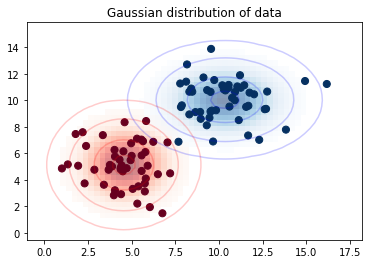

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

xlim = (min(X[:, 0]) - 2, max(X[:, 0]) + 2 )
ylim = (min(X[:, 1]) - 2, max(X[:, 1]) + 2 )

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu)**2 / std**2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5, cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape), levels=[0.01, 0.1, 0.5, 0.9], colors = color, alpha=0.2)

ax.set(xlim=xlim, ylim=ylim)

plt.title('Gaussian distribution of data')
plt.show()

In [58]:
gaussian_nb.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gaussian_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [60]:
gaussian_nb.predict_proba(X_test)

array([[9.99999746e-01, 2.54140753e-07],
       [7.63749214e-14, 1.00000000e+00],
       [4.23038642e-03, 9.95769614e-01],
       [9.99986614e-01, 1.33855473e-05],
       [7.05769182e-06, 9.99992942e-01],
       [9.99820566e-01, 1.79433743e-04],
       [9.72541524e-01, 2.74584756e-02],
       [9.99982043e-01, 1.79572091e-05],
       [2.85910189e-05, 9.99971409e-01],
       [1.01888837e-07, 9.99999898e-01],
       [7.39129058e-01, 2.60870942e-01],
       [9.99793438e-01, 2.06561658e-04],
       [9.99999915e-01, 8.46737165e-08],
       [2.03213294e-05, 9.99979679e-01],
       [8.76198350e-09, 9.99999991e-01],
       [6.51163513e-05, 9.99934884e-01],
       [9.27638525e-05, 9.99907236e-01],
       [7.58034673e-09, 9.99999992e-01],
       [1.81773339e-03, 9.98182267e-01],
       [9.99985544e-01, 1.44557945e-05]])

## Multiclass classification

In [61]:
X, y = make_blobs(n_samples = 100,
                    n_features =2,
                    centers = [[5,5], [10,10], [20,20]],
                    cluster_std = 1.5,
                    random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [62]:
gaussian_nb_mc = GaussianNB()
gaussian_nb_mc.fit(X_train, y_train)

Mean:  [[ 4.94844927  4.67947138]
 [ 9.62097704 10.49990402]
 [19.63832097 19.94706375]]
Variance:  [[1.99332345 2.36976247]
 [1.68415535 2.25596351]
 [1.79203315 1.24939267]]
Priors:  [0.3375 0.35   0.3125]


In [63]:
print(classification_report(y_test, gaussian_nb_mc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [64]:
gaussian_nb_mc.predict_proba(X_test)

array([[1.02996770e-47, 2.67740135e-24, 1.00000000e+00],
       [5.00111567e-05, 9.99949989e-01, 6.51529293e-32],
       [9.99999999e-01, 9.45325297e-10, 1.33290144e-78],
       [1.00000000e+00, 6.49743430e-12, 7.70260328e-90],
       [1.50617094e-52, 5.94123831e-27, 1.00000000e+00],
       [3.77917160e-47, 9.99218112e-23, 1.00000000e+00],
       [5.30598294e-33, 9.05195020e-13, 1.00000000e+00],
       [6.63950534e-07, 9.99999336e-01, 1.42699786e-26],
       [3.57244754e-61, 3.86494439e-34, 1.00000000e+00],
       [9.70872284e-06, 9.99990291e-01, 5.02104511e-31],
       [9.99982252e-01, 1.77477098e-05, 2.51366893e-63],
       [3.93493321e-39, 5.51495730e-18, 1.00000000e+00],
       [1.00000000e+00, 4.72574372e-11, 1.19906531e-79],
       [1.19575291e-47, 3.45203067e-24, 1.00000000e+00],
       [9.09245241e-01, 9.07547595e-02, 1.30885257e-46],
       [9.99999997e-01, 2.64110663e-09, 3.37901343e-80],
       [9.97572472e-01, 2.42752753e-03, 1.17514148e-55],
       [1.12896485e-05, 9.99988

## MultinomialNB

In [65]:
class MultinomialNB(object):
    def fit(self, X, y, alpha = 1.0):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_prior = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(n_classes):
            X_c = X[y == c]

            total_count = np.sum(X_c, axis=1)
            self.w[idx, :] = (np.sum(X_c, axis=0) + alpha) / (total_count + alpha * n_features)

            self.w_prior[idx] = (X_c.shape[0] + alpha) / float(n_samples + alpha * n_classes)

    def log_likelihood_prior_prod(self, X):
        return X @ (np.log(self.w).T) + np.log(self.w_prior) 

    def predict(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.argmax(q, axis = 1)

    def predict_proba(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q) / np.expand_dims(np.sum(np.exp(q), axis = 1), axis = 1)